In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext jupyternotify

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score

from task3_utils_niklas import *

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Preprocessing

In [2]:
train = pd.read_csv("./handout/train.csv")
# highly imbalanced classes
# train.iloc[:,1].value_counts()
train = pd.concat([train,train.Sequence.str.split("",expand=True)],axis=1,ignore_index=True)
train = train.drop(columns = {0,2,7})
train.rename(columns={1:"Active",3:"site1",4:"site2",5:"site3",6:"site4"},inplace=True)

The first step is to separate the letter from each other, creating a data frame with each site letter

In [8]:
train

,Active,site1,site2,site3,site4
0,0,D,K,W,L
1,0,F,C,H,N
2,0,K,D,Q,P
3,0,F,N,W,I
4,0,N,K,R,M
...,...,...,...,...,...
111995,0,G,S,M,E
111996,0,D,L,P,T
111997,0,S,G,H,C
111998,0,K,I,G,T


As an exploratory step, we try LabelEncoder and also SMOTE oversampler for the class imbalance

In [9]:
import string
string.ascii_uppercase

# highly imbalanced classes
# train.iloc[:,1].value_counts()
le = LabelEncoder()
le.fit_transform(list(string.ascii_uppercase))

train.site1 = le.transform(train.site1)
train.site2 = le.transform(train.site2)
train.site3 = le.transform(train.site3)
train.site4 = le.transform(train.site4)

In [10]:
X = train.loc[:,"site1":"site4"]
y = train["Active"]
X, y = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)

In [11]:
X_train

,site1,site2,site3,site4
76367,18,15,21,17
30534,2,6,21,6
205006,24,7,6,0
112915,16,2,24,6
151936,22,2,11,2
...,...,...,...,...
196053,3,24,24,6
71567,6,17,19,10
145724,22,17,5,2
132231,12,18,6,2


# Model Fitting

## Elasticnet approach

First, we try the elasticnet approach (which is a combination of Lasso and Rigde). We cross validate across different ratios to find the best hyperparameter setups

In [12]:
penalty = ['elasticnet']
C = [2**-1, 2**1, 2**3, 2**5, 2**7, 2**9, 2**11]
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(LogisticRegression(solver = "saga",class_weight = "balanced",l1_ratio=1),
                   hyperparameters, cv=5, verbose=1,n_jobs=-1)
best_model = clf.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   12.5s finished


In [13]:
print(best_model.best_estimator_)
f1_score(y_test, best_model.predict(X_test))

LogisticRegression(C=32, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=1,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)


0.7011328897680275

The results we disappointing, so we will attempt another approach

## ANN Preprocessing

In [15]:
train = pd.read_csv("./handout/train.csv")
train = pd.concat([train,train.Sequence.str.split("",expand=True)],axis=1,ignore_index=True)
train = train.drop(columns = {0,2,7})
train.rename(columns={1:"Active",3:"site1",4:"site2",5:"site3",6:"site4"},inplace=True)

test = pd.read_csv('./handout/test.csv')
test = pd.concat([test,test.Sequence.str.split("",expand=True)],axis=1,ignore_index=True)
test = test.drop(columns = {0,1,6})
test.rename(columns={2:"site1",3:"site2",4:"site3",5:"site4"},inplace=True)

For this approach, we use the one hot vector approach, which create vectors of length(unique(classes)) and for each observation, sets the value of its class to 1, and rest to 0

In [16]:
# One-hot-encoder: train set
X = train.loc[:,'site1':]
y = train.loc[:,'Active']

ohe = OneHotEncoder()
X = ohe.fit_transform(X).toarray()

In [17]:
# One-hot-encoder: test set
X_ = test.loc[:,'site1':]
X_ = ohe.transform(X_).toarray()

In [18]:
# class imbalance and train-test split
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X,y)
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.1,random_state=0)

In [23]:
print(pd.DataFrame(X_train).shape)

(194016, 80)


## MLP sklearn

First, we try a non-tuned MLP classifier:

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(30,10),random_state=0,verbose=1)
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_)

Iteration 1, loss = 0.17894362
Iteration 2, loss = 0.06880669
Iteration 3, loss = 0.04921786
Iteration 4, loss = 0.04026760
Iteration 5, loss = 0.03502176
Iteration 6, loss = 0.03107393
Iteration 7, loss = 0.02828790
Iteration 8, loss = 0.02606608
Iteration 9, loss = 0.02422389
Iteration 10, loss = 0.02235044
Iteration 11, loss = 0.02112169
Iteration 12, loss = 0.01971965
Iteration 13, loss = 0.01859136
Iteration 14, loss = 0.01760540
Iteration 15, loss = 0.01680168
Iteration 16, loss = 0.01581384
Iteration 17, loss = 0.01525181
Iteration 18, loss = 0.01514601
Iteration 19, loss = 0.01427252
Iteration 20, loss = 0.01392648
Iteration 21, loss = 0.01314179
Iteration 22, loss = 0.01282813
Iteration 23, loss = 0.01260365
Iteration 24, loss = 0.01223055
Iteration 25, loss = 0.01185170
Iteration 26, loss = 0.01127747
Iteration 27, loss = 0.01100604
Iteration 28, loss = 0.01061408
Iteration 29, loss = 0.01058282
Iteration 30, loss = 0.00993527
Iteration 31, loss = 0.01012650
Iteration 32, los

In [28]:
print("train f1 score: ",f1_score(y_test,mlp.predict(X_test)))
print("train ROC score: ",roc_auc_score(y_train,mlp.predict(X_train)))
print("test ROC score: ",roc_auc_score(y_test,mlp.predict(X_test)))

train f1 score:  0.9960354047575143
train ROC score:  0.9996238354357325
test ROC score:  0.996001859600186


This approach overfits a lot, so we try some regularization, using dropouts and kernel regulizers

## Keras

In [29]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


The following deep network is discovered using trial and erros, we attempted different combinations, and TALOS package for hyperparameter optimization. 
The dropouts, kernel regulizers, and activations are used to avoid overfitting. So is the early stopping call.

In [43]:
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

model = Sequential()
model.add(Dense(100, input_dim=80, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-1, l2=1e-1)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-1, l2=1e-1)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

usualCallback = EarlyStopping()
overfitCallback = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience = 20)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

In [47]:
history = model.fit(X_train, to_categorical(y_train),batch_size=32,validation_data = (X_test,to_categorical(y_test)), 
                    epochs=150,callbacks=[overfitCallback],class_weight='balanced')
predictions = model.predict_classes(X_)

Train on 194016 samples, validate on 21558 samples
Epoch 1/150
194016/194016 [==============================] - 11s 56us/step - loss: 0.4502 - f1: 0.9832 - val_loss: 0.3505 - val_f1: 0.9903
Epoch 2/150
194016/194016 [==============================] - 11s 57us/step - loss: 0.4018 - f1: 0.9839 - val_loss: 0.2913 - val_f1: 0.9914
Epoch 3/150
194016/194016 [==============================] - 12s 63us/step - loss: 0.4418 - f1: 0.9831 - val_loss: 0.3489 - val_f1: 0.9917
Epoch 4/150
194016/194016 [==============================] - 11s 56us/step - loss: 0.4249 - f1: 0.9836 - val_loss: 0.3094 - val_f1: 0.9892
Epoch 5/150
194016/194016 [==============================] - 11s 57us/step - loss: 0.4733 - f1: 0.9840 - val_loss: 0.4445 - val_f1: 0.9910
Epoch 6/150
194016/194016 [==============================] - 12s 63us/step - loss: 0.4340 - f1: 0.9851 - val_loss: 0.4369 - val_f1: 0.9922
Epoch 7/150
194016/194016 [==============================] - 12s 62us/step - loss: 0.4444 - f1: 0.9861 - val_loss: 

In [48]:
print("train f1 score: ",f1_score(y_test,model.predict_classes(X_test)))
print("train ROC score: ",roc_auc_score(y_train,model.predict_classes(X_train)))
print("test ROC score: ",roc_auc_score(y_test,model.predict_classes(X_test)))

train f1 score:  0.9933164323576861
train ROC score:  0.9964335820230306
test ROC score:  0.9932647331420801


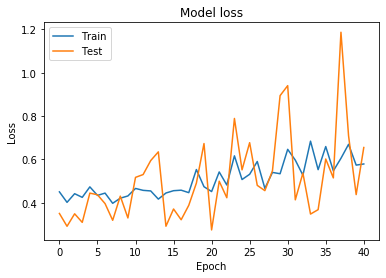

In [49]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# Write to file

In [50]:
np.savetxt("./toSubmit/toSubmit-F.csv", predictions,fmt='%3d', delimiter=";")